In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary

import time
import copy
import os

In [6]:
data_dir = '../datasets/camouflage_image_segmentation/Images'
mask_dir = '../datasets/camouflage_image_segmentation/Masks'

In [7]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256,256)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Train2': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=1),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Train3': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomVerticalFlip(p=1),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((256,256)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'Train2': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    'Train3': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomVerticalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

In [8]:
class ImageMaskDataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, transform2 = None, mask_transform = None, mask_transform2 = None) -> None:
        super(ImageMaskDataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                file2 = mask_dir+'/Train/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                    for i in range(len(transform2)):
                        self.imgs.append((transform2[i](Image.open(file1.path).convert('RGB')),mask_transform2[i](Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
        else:
            for file1 in os.scandir(data_dir+'/Validation'):
                file2 = mask_dir+'/Validation/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
                    # if self.imgs[-1][0].shape[0] == 1:
                    #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [9]:
train_data = ImageMaskDataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], transform2=[data_transforms['Train2'], data_transforms['Train3']], mask_transform=mask_transforms['Train'], mask_transform2=[mask_transforms['Train2'], mask_transforms['Train3']])
val_data = ImageMaskDataset(data_dir, mask_dir, train = False, transform=data_transforms['Validation'], mask_transform=mask_transforms['Validation'])

In [10]:
train_loader = DataLoader(
    train_data,
    batch_size = 16,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 16,
    shuffle = True,
)

In [11]:
def image_show(image, mask, pred = None):
    image = image*0.5 + 0.5
    mask = mask*0.5 + 0.5
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')

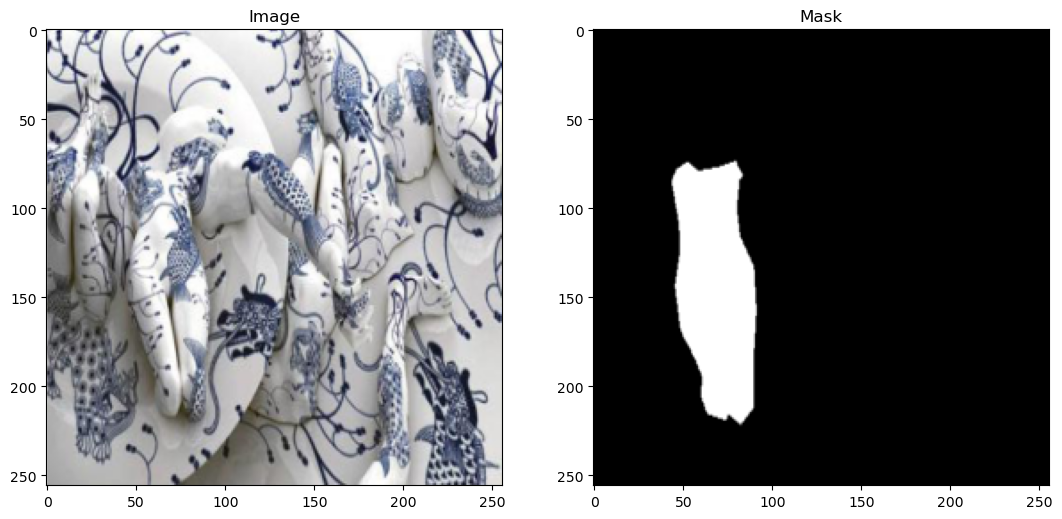

In [12]:
dataiter = iter(train_loader)
image, mask = next(dataiter)
index = 0
image_show(image[index], mask[index])

In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [14]:
deeplab = deeplabv3_resnet101(pretrained=True, progress = True)
deeplab.classifier = DeepLabHead(2048, 1)
deeplab.train()

/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [15]:
total_params = sum(param.numel() for param in deeplab.parameters() if param.requires_grad)
total_params

60991062

In [16]:
deeplab = deeplab.to(device)

# IoU Function

In [17]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, preds, masks):     
        preds = preds.view(-1)
        masks = masks.view(-1)
        
        intersection = (preds * masks).sum()
        total = (preds + masks).sum()
        union = total - intersection 
        
        IoU = intersection/union
                
        return 1 - IoU

In [18]:
def binaryJaccardIndex(preds, masks):
    intersection = 0
    union = 0
    preds = preds.view(-1) # Reshaping to a single array
    masks = masks.view(-1) # Reshaping to a single array

    intersection = (preds * masks).sum()
    total = (preds + masks).sum()
    union = total - intersection 
    
    IoU = intersection/union
            
    return IoU

In [19]:
criterion = IoULoss()
optimizer = torch.optim.SGD(deeplab.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)

In [20]:
num_epochs = 10
batches = len(train_loader)
losses = []
print(batches)

188


In [21]:
best_weights = copy.deepcopy(deeplab.state_dict())
max = 0
val_iou_score = 0
tic = time.time()
for epoch in range(num_epochs):
    deeplab.train()
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)
        
        preds = deeplab(images)
        preds = torch.sigmoid(preds['out'])
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    with torch.no_grad():
        deeplab.eval()
        val_iou_score = 0
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to('cpu')
            pred = deeplab(image)['out']
            pred = torch.sigmoid(pred).cpu()
            pred = torch.round(pred)
            val_iou_score += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
        val_iou_score = val_iou_score/len(val_loader)

        if (max <= val_iou_score):
            print('SAVED MODEL WEIGHTS')
            max = val_iou_score
            best_weights = copy.deepcopy(deeplab.state_dict())
    
    print(f'Validation IoU Score: {val_iou_score:.4f}')
    print(f'Validation Dice Score: {(2*val_iou_score)/(1+val_iou_score):.4f}')
    print("-"*20)
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/10; LR = 0.1
Step 1/188; Loss = 0.8034
Step 2/188; Loss = 0.7703
Step 3/188; Loss = 0.8002
Step 4/188; Loss = 0.8403
Step 5/188; Loss = 0.8052
Step 6/188; Loss = 0.7957
Step 7/188; Loss = 0.7453
Step 8/188; Loss = 0.7621
Step 9/188; Loss = 0.6930
Step 10/188; Loss = 0.7158
Step 11/188; Loss = 0.6288
Step 12/188; Loss = 0.7311
Step 13/188; Loss = 0.6951
Step 14/188; Loss = 0.6461
Step 15/188; Loss = 0.5787
Step 16/188; Loss = 0.6940
Step 17/188; Loss = 0.6372
Step 18/188; Loss = 0.5845
Step 19/188; Loss = 0.6355
Step 20/188; Loss = 0.5494
Step 21/188; Loss = 0.6352
Step 22/188; Loss = 0.5863
Step 23/188; Loss = 0.5526
Step 24/188; Loss = 0.5644
Step 25/188; Loss = 0.5443
Step 26/188; Loss = 0.5968
Step 27/188; Loss = 0.5658
Step 28/188; Loss = 0.6332
Step 29/188; Loss = 0.5453
Step 30/188; Loss = 0.5505
Step 31/188; Loss = 0.4878
Step 32/188; Loss = 0.5662
Step 33/188; Loss = 0.5945
Step 34/188; Loss = 0.4795
Step 35/188; Loss = 0.4273
Step 36/188; Loss = 0.4608
Step 37/188; Los

Text(0.5, 1.0, 'Loss vs Epochs')

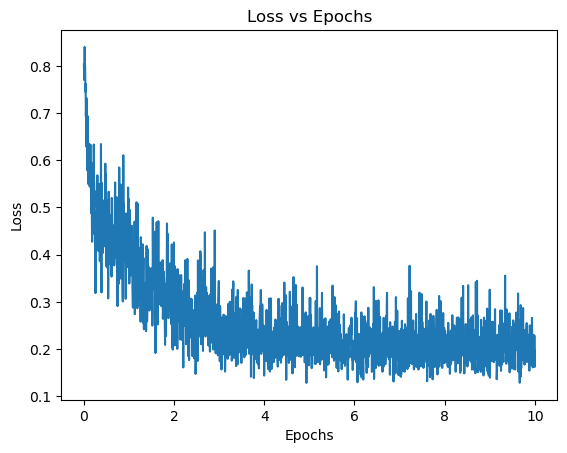

In [22]:
plt.plot(np.linspace(0,num_epochs,len(losses)),losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

In [23]:
deeplab.load_state_dict(best_weights)
torch.save(deeplab, '../models/DeepLabV3_IoULoss_Image_Segmentation_Vertical_256.pt')

In [24]:
deeplab = torch.load('../models/DeepLabV3_IoULoss_Image_Segmentation_Vertical_256.pt')
deeplab.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Testing

In [25]:
threshold = 0.5

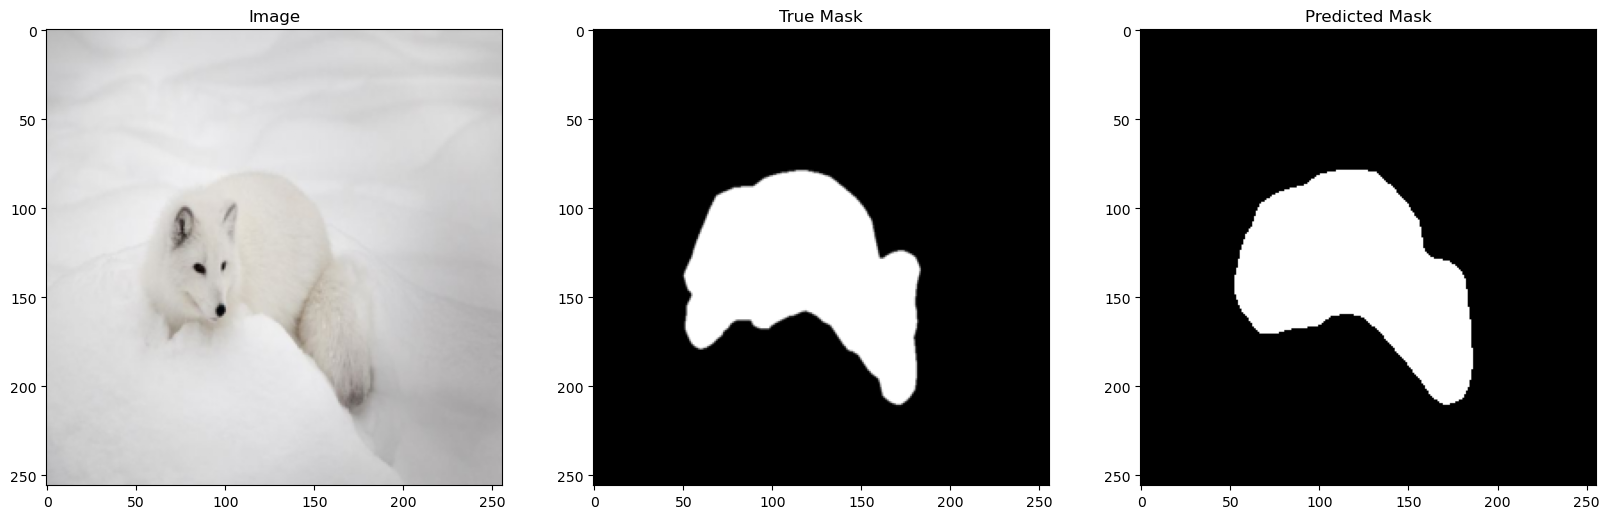

In [27]:
with torch.no_grad():
    image, mask = next(iter(train_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = deeplab(image)['out'].cpu()
    pred1 = torch.relu(torch.sign(pred - threshold))
    image = image.to('cpu')
    image_show(image[0], mask[0], pred1[0])

In [28]:
IoU_value = 0
with torch.no_grad():
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = deeplab(image)['out'].cpu()
        pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
        IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
    print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

Intersection Over Union value = 0.7995158433914185


In [29]:
iou = IoU_value/len(train_loader)
dice_score = 2*iou/(1+iou)
print('Dice Score for Training data =',dice_score.item())

Dice Score for Training data = 0.8885899186134338


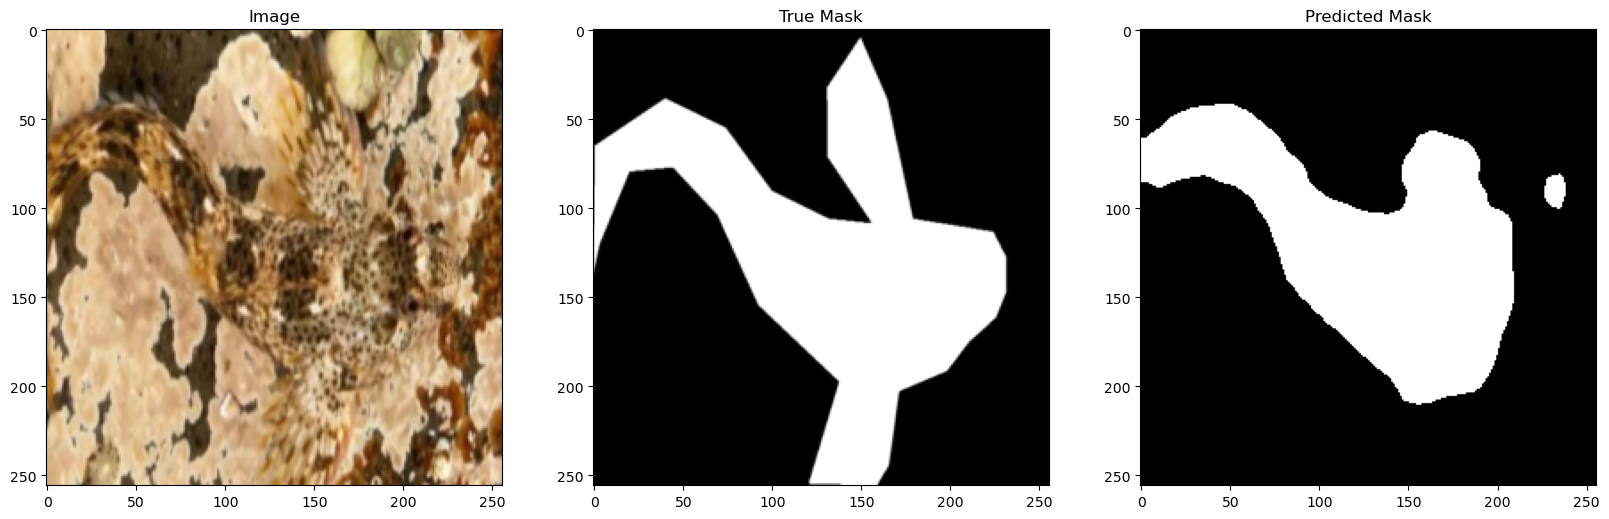

In [30]:
with torch.no_grad():
    image, mask = next(iter(val_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = deeplab(image)['out'].cpu()
    pred1 = torch.relu(torch.sign(pred - threshold))
    image = image.to('cpu')
    image_show(image[0], mask[0], pred1[0])

In [31]:
IoU_value = 0
with torch.no_grad():
    for image, mask in val_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = deeplab(image)['out'].cpu()
        pred = torch.relu(torch.sign(pred - threshold))
        IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
    print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.6373192667961121


In [32]:
iou = IoU_value/len(val_loader)
dice_score = 2*iou/(1+iou)
print('Dice Score for Validation data =',dice_score.item())

Dice Score for Validation data = 0.7784910798072815
